# Semi classical

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [2]:
MHz = 2*np.pi
us = 1

In [3]:
kappa_2 = 1 * MHz
n_bar = np.linspace(1, 5, 11)
alpha_0 = 1e-1

t = np.linspace(0, 1.5, 20_001)*us


def evol(alpha, t, alpha_inf):
    return -kappa_2 * alpha * (alpha**2 - alpha_inf**2)


sols = np.zeros(n_bar.shape + t.shape)
for ind, n in enumerate(n_bar):
    alpha_inf = np.sqrt(n)
    sols[ind] = odeint(evol, y0=alpha_0, t=t, args=(alpha_inf,))[:, 0]

In [4]:
def inflate_class(t, kappa_2, alpha_inf, alpha_0):
    t0 = np.log((alpha_inf/alpha_0)**2 - 1)/2/kappa_2/alpha_inf**2
    kappa_inf = 2*kappa_2*alpha_inf**2
    return alpha_inf**2/(1+np.exp(-kappa_inf*(t-t0)))

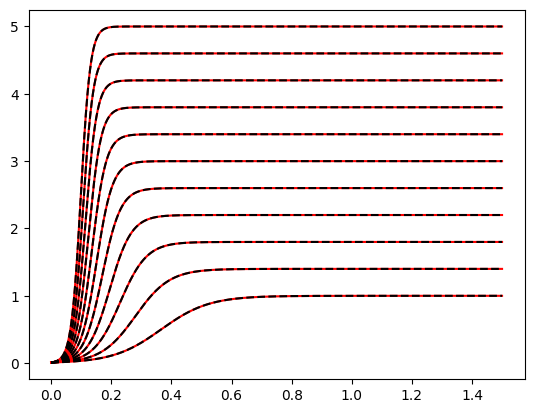

In [5]:
plt.plot(t, sols.T**2, "r-")
plt.plot(t, inflate_class(t[:, None], kappa_2, np.sqrt(n_bar)[None, :], alpha_0), 'k--')
plt.show()

## Semi Quantum

In [6]:
import dynamiqs as dq
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [7]:
def inflate_class(t, kappa_2, alpha_inf, alpha_0):
    t0 = jnp.log((alpha_inf/alpha_0)**2 - 1)/2/kappa_2/alpha_inf**2 + 0.05
    kappa_inf = 2*kappa_2*alpha_inf**2
    return alpha_inf**2/(1+jnp.exp(-kappa_inf*(t-t0)))

In [8]:
ninf = 4
Na = 5*ninf
kappa_2 = 1*MHz

kappa_inf = 2*kappa_2*ninf
tsave = jnp.linspace(0, 20/kappa_inf, 201)
phi_0 = dq.fock(Na, 0)
a = dq.destroy(Na)
output = dq.mesolve(0*dq.eye(Na), [jnp.sqrt(kappa_2)*(a@a-ninf*dq.eye(Na))], phi_0, tsave, exp_ops=[dq.dag(a)@a])

2024-06-12 10:04:54.835837: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
|███████████████████████████████████████████████████████████| 100.0% ◆ total 0.10s ◆ remaining 00:00


In [12]:
def bell_curve(x, sigma):
    return jnp.exp(-x**2/2/sigma**2)/jnp.sqrt(2*jnp.pi*sigma**2)

In [13]:
sigma = 1/2
alpha_0 = jnp.linspace(-1, 1, 100_000)*np.sqrt(ninf)*0.99999
trajectories_alpha = jnp.sqrt(inflate_class(tsave[:, None], kappa_2, jnp.sqrt(ninf), alpha_0[None, :]))
trajectories = inflate_class(tsave[:, None], kappa_2, jnp.sqrt(ninf), alpha_0[None, :])
quant_approx = (jnp.sum(trajectories_alpha*bell_curve(alpha_0, sigma)[None, :]*(alpha_0[1] - alpha_0[0]), axis=1))**2
quant_approx_2 = jnp.sum(trajectories*bell_curve(alpha_0, sigma)[None, :]*(alpha_0[1] - alpha_0[0]), axis=1)

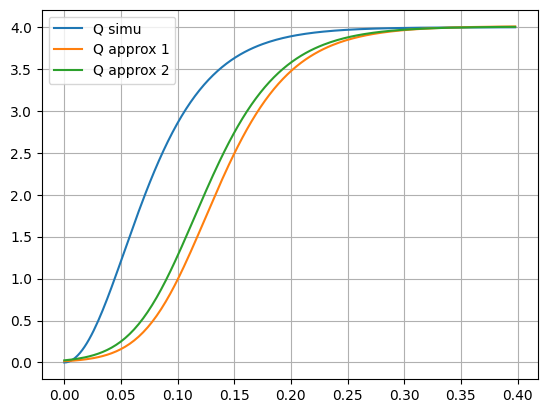

In [16]:
plt.plot(tsave, output.expects[0].real, label="Q simu")
plt.plot(tsave, quant_approx, label="Q approx 1")
plt.plot(tsave, quant_approx_2, label="Q approx 2")
plt.grid()
plt.legend()

# Quantum

In [17]:
import dynamiqs as dq
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import jax.numpy as jnp

In [18]:
MHz = 2*jnp.pi
us = 1

In [19]:
Na, Nb = 30, 10

a, b = dq.destroy(Na, Nb)

kappa_b = 15*MHz

n_t = 501

rho0 = dq.tensor(dq.fock(Na, 0), dq.fock(Nb, 0))

In [20]:
def H_inflate(g2, eds, a, b):
    H = g2*a@a@dq.dag(b) + eds*b
    return H+dq.dag(H)

In [21]:
def simulate(alpha_m_2, g2):
    eds = alpha_m_2*g2
    H = H_inflate(g2, eds[:, None, None], a[None, :, :], b[None, :, :])
    c_ops = [jnp.sqrt(kappa_b)*b]
    kappa_2 = 4*g2**2/kappa_b
    kappa_conf = kappa_2*alpha_m_2
    tsave = jnp.linspace(0, 10/jnp.min(kappa_conf), n_t)
    output = dq.mesolve(H, c_ops, rho0, tsave, exp_ops=[dq.dag(a)@a, a@dq.dag(a) - dq.dag(a)@a, b@dq.dag(b) - dq.dag(b)@b])
    return output.expects, tsave

In [22]:
alphas_m_2 = jnp.linspace(2, 6, 5)
g2s = jnp.linspace(0.5, 3, 3)*MHz

results = jnp.zeros((len(g2s), len(alphas_m_2), 3, n_t), dtype=complex)
tsaves = jnp.zeros((len(g2s), n_t))
for ind, g2 in enumerate(g2s):
    expects, tsave = simulate(alphas_m_2, g2)
    results = results.at[ind].set(expects)
    tsaves = tsaves.at[ind].set(tsave)

2024-06-12 10:06:43.744822: W external/xla/xla/service/hlo_rematerialization.cc:2948] Can't reduce memory use below 3.97GiB (4264764731 bytes) by rematerialization; only reduced to 4.03GiB (4330290927 bytes), down from 4.03GiB (4330290927 bytes) originally
|███████████████████████████████████████████████████████████| 100.0% ◆ total 6.64s ◆ remaining 00:00
|███████████████████████████████████████████████████████████| 100.0% ◆ total 1.37s ◆ remaining 00:00
|███████████████████████████████████████████████████████████| 100.0% ◆ total 0.73s ◆ remaining 00:00


In [23]:
def sigmoid(t, t0, A, T_inflate):
    return A / (1 + jnp.exp(-(t - t0) / T_inflate))

In [24]:
def ext_exp(t, alpha):
    if alpha == 1:
        return jnp.exp(t)
    calpha = 1/(alpha-1)
    return (1-t/calpha)**(1/(1-alpha))

In [25]:
def ext_sigmoid(t, t0, A, T_inflate, alpha):
    if alpha == 1:
        return A / (1 + jnp.exp(-(t - t0) / T_inflate))
    calpha = 1/(alpha-1)
    xs = -(t - t0) / T_inflate
    xs_sup = xs >= calpha
    xs_inf = xs < calpha
    ext_exp_loc = ext_exp(xs, alpha)
    sigmoid_res = A / (1 + ext_exp_loc)
    if alpha < 1:
        sigmoid_res = sigmoid_res.at[xs_inf].set(A)
    else:
        sigmoid_res = sigmoid_res.at[xs_sup].set(0)
    return sigmoid_res

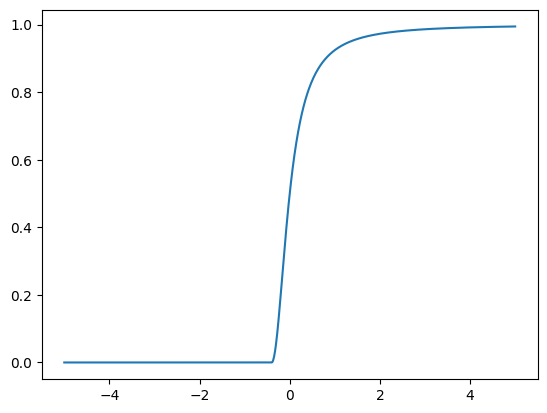

In [26]:
xs = jnp.linspace(-5, 5, 1000)
plt.plot(xs, ext_sigmoid(xs, 0, 1, 0.2, 1.5))

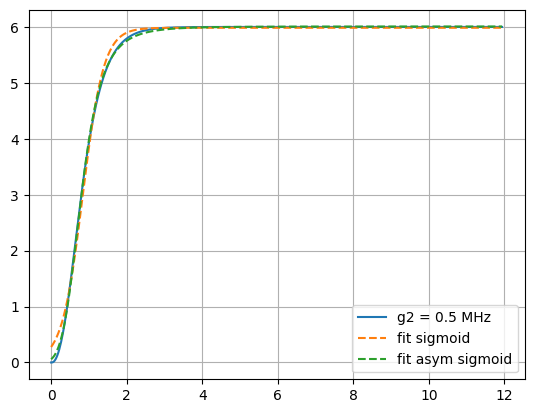

In [30]:
n_zero = 0
to_fit = jnp.concatenate((jnp.zeros(n_zero), results[0, -1, 0, :].real))
time_fit = jnp.concatenate((jnp.linspace(-tsaves[0, -1]/4, 0, n_zero, endpoint=False), tsaves[0]))
plt.plot(time_fit, to_fit, label='g2 = 0.5 MHz')

guess = [0., 6, 1]
popt, pcov = curve_fit(sigmoid, time_fit, to_fit, p0=guess)
plt.plot(time_fit, sigmoid(time_fit, *popt), "--", label='fit sigmoid')

guess = [0., 6, 1, 1]
popt, pcov = curve_fit(ext_sigmoid, time_fit, to_fit, p0=guess)
plt.plot(time_fit, ext_sigmoid(time_fit, *popt), "--", label='fit asym sigmoid')
plt.legend()
plt.grid()

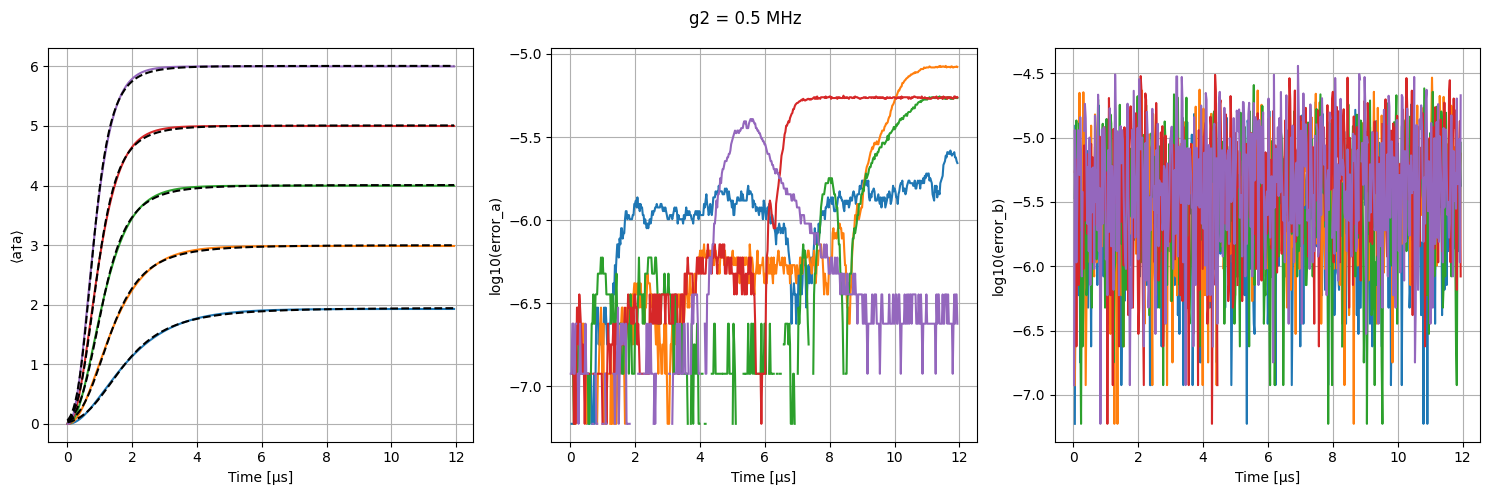

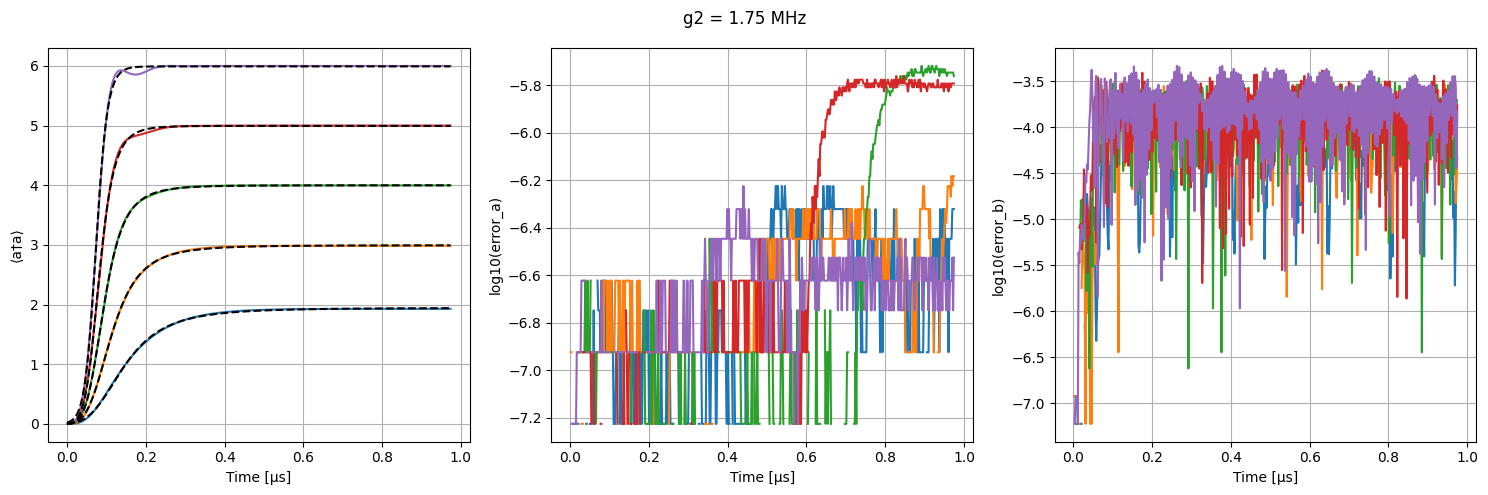

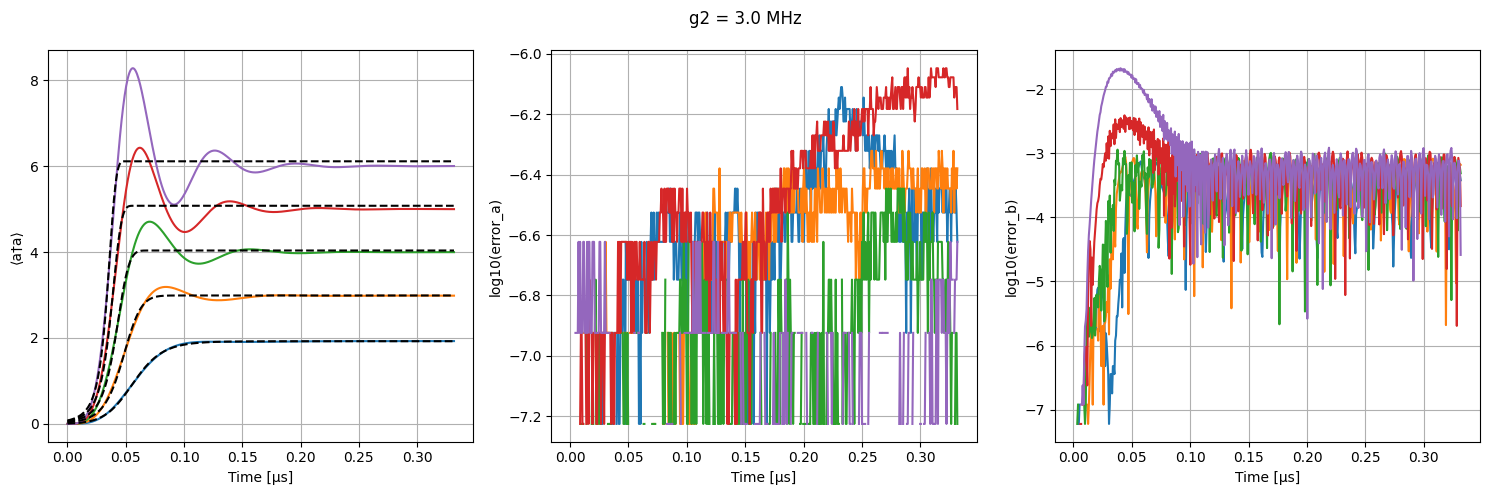

In [35]:
popts = np.zeros((len(g2s), len(alphas_m_2), 4))
for ind, g2_plot in enumerate(g2s):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].plot(tsaves[ind], results[ind, :, 0].real.T)
    for ind_al, alpha_2 in enumerate(alphas_m_2):
        kappa_2 = 4*g2_plot**2/kappa_b
        T_infl = 1/2/kappa_2/alpha_2
        guess = [T_infl, alpha_2, T_infl, 1]
        #ax[0].plot(tsaves[ind], ext_sigmoid(tsaves[ind], *guess), "k--")
        popt, _ = curve_fit(ext_sigmoid, tsaves[ind], results[ind, ind_al, 0].real, p0=guess)
        ax[0].plot(tsaves[ind], ext_sigmoid(tsaves[ind], *popt), "k--")
        # popt, _ = curve_fit(sigmoid, tsaves[ind], results[ind, ind_al, 0].real, p0=guess[:-1])
        # ax[0].plot(tsaves[ind], sigmoid(tsaves[ind], *popt), "k--")
        popts[ind, ind_al, :len(popt)] = popt
        
    ax[0].set_ylabel('⟨a†a⟩')
    ax[1].plot(tsaves[ind], jnp.log10(jnp.abs(results[ind, :, 1].real.T-1)))
    ax[1].set_ylabel('log10(error_a)')
    ax[2].plot(tsaves[ind], jnp.log10(jnp.abs(results[ind, :, 2].real.T-1)))
    ax[2].set_ylabel('log10(error_b)')

    for sa in ax.flatten():
        sa.grid()
        sa.set_xlabel('Time [µs]')
    fig.suptitle(f'g2 = {g2_plot/MHz} MHz')
    fig.tight_layout()
    plt.show()

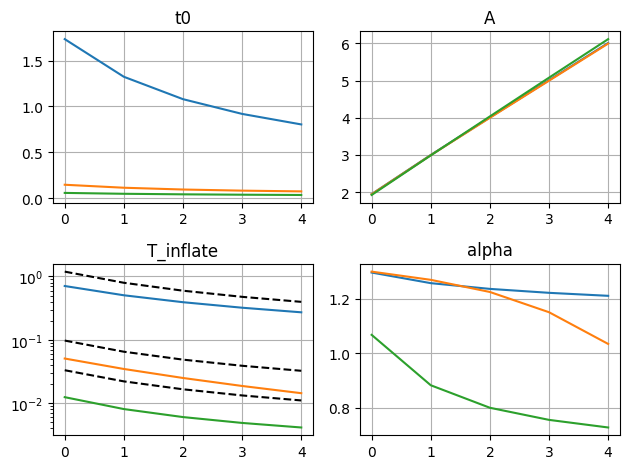

In [37]:
fig, ax = plt.subplots(2, 2)
for a, d, t in zip(ax.flatten(), np.swapaxes(popts, -1, 0), ["t0", "A", "T_inflate", "alpha"]):
    a.plot(d)
    a.grid()
    a.set_title(t)
kappas_2 = 4*g2s**2/kappa_b
ax[1, 0].plot(1/kappas_2[None, :]/alphas_m_2[:, None], 'k--')
ax[1, 0].set_yscale('log')
fig.tight_layout()

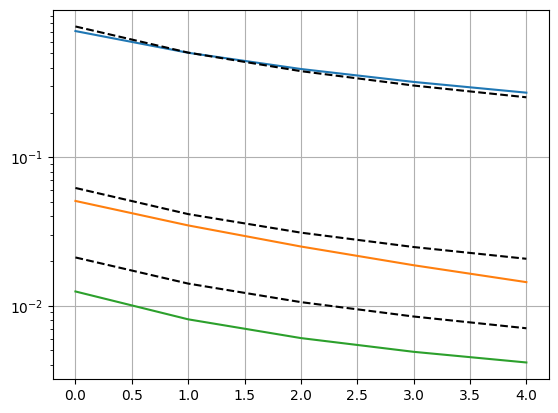

In [53]:
plt.plot(popts[:, :, 2].T)
plt.plot(1/kappas_2[None, :]/alphas_m_2[:, None]*2/np.pi, 'k--')
plt.grid()
plt.yscale('log')

# Comparing one mode - two mode and semi-classicals

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import dynamiqs as dq

In [2]:
MHz = 2*np.pi
us = 1

In [3]:
n_inf = 4
kappa_2 = 1*MHz
kappa_b = 15*MHz
n_t = 501
kappa_conf = min(kappa_2*n_inf, kappa_b/4)
tsaves = np.linspace(0, 10/kappa_conf, n_t)
t_classic = np.linspace(0, tsaves[-1], 20_001)

In [4]:
Na = 20
a = dq.destroy(Na)
H = 0*dq.eye(Na)
c_ops = [np.sqrt(kappa_2)*(a@a - dq.eye(Na)*n_inf)]
rho0 = dq.fock(Na, 0)
output_1_m = dq.mesolve(H, c_ops, rho0, tsaves, exp_ops=[dq.dag(a)@a, a@a, a@dq.dag(a) - dq.dag(a)@a])
print(np.max(np.abs(output_1_m.expects[-1] - 1)))

2024-06-07 13:52:13.374246: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
100.00%|██████████████████████████████████████████████████████████████████| [00:00<00:00, 939.54%/s]

1.4305115e-06


In [11]:
Na, Nb = 30, 20
a, b = dq.destroy(Na, Nb)
g2 = np.sqrt(kappa_2*kappa_b)/2
eds = -n_inf*g2
H = g2*a@a@dq.dag(b) + eds*b
H += dq.dag(H)
c_ops = [np.sqrt(kappa_b)*b]
rho0 = dq.tensor(dq.fock(Na, 0), dq.fock(Nb, 0))
output_2_m = dq.mesolve(H, c_ops, rho0, tsaves, exp_ops=[dq.dag(a)@a, a@a, b, a@dq.dag(a) - dq.dag(a)@a, b@dq.dag(b) - dq.dag(b)@b])
print(np.max(np.abs(output_2_m.expects[-2] - 1)), np.max(np.abs(output_2_m.expects[-1] - 1)))

100.00%|███████████████████████████████████████████████████████████████████| [00:01<00:00, 87.46%/s]

4.172325e-07 7.0273876e-05


In [12]:
alpha_0 = 1e-1

def evol(alpha, t):
    return -kappa_2 * alpha * (alpha**2 - n_inf)
    
sol_alpha = odeint(evol, y0=alpha_0, t=t_classic)[:, 0]

In [13]:
n_0, alpha_2_0 = 0, 0

def evol2(x, t):
    n, alpha_2 = x
    dxdt = np.array([
        2*n**2 - 2*alpha_2*n_inf,
        (2*n+1)*(alpha_2 - n_inf)
    ])
    return -kappa_2*dxdt
sol_n_alpha_2 = odeint(evol2, y0=[n_0, alpha_2_0], t=t_classic).T

In [14]:
alpha_0, beta_0 = 0.1, 0

def evol3(x, t):
    alpha, beta = x
    return np.array([
        2*g2*alpha*beta,
        - eds - kappa_b*beta/2 - g2*alpha**2,
    ])
sol_2_mode = odeint(evol3, y0=[alpha_0, beta_0], t=t_classic).T

In [15]:
n_0, alpha_2_0, beta_0 = 0, 0, 0

def evol4(x, t):
    n, alpha_2, beta = x
    return np.array([
        2*g2*beta*2*alpha_2,
        2*g2*beta*(2*n+1),
        - eds - kappa_b*beta/2 - g2*alpha_2,
    ])
sol_n_alpha_2_2_mode = odeint(evol4, y0=[n_0, alpha_2_0, beta_0], t=t_classic).T

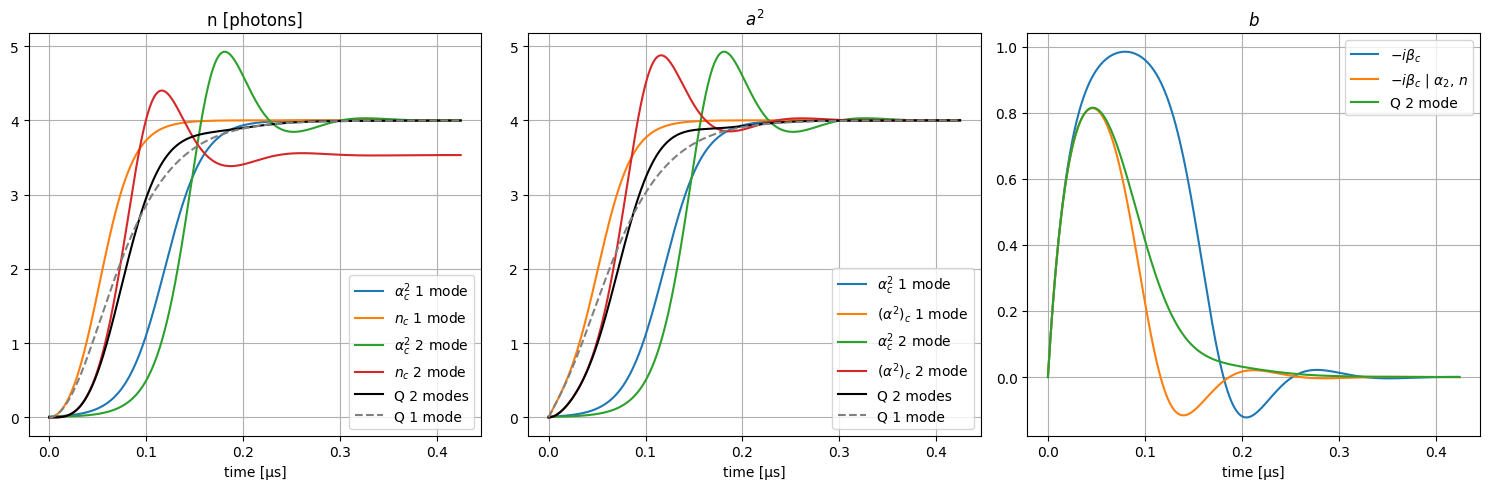

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(t_classic, sol_alpha**2, label=r"$\alpha_c^2$ 1 mode")
ax[1].plot(t_classic, sol_alpha**2, label=r"$\alpha_c^2$ 1 mode")

ax[0].plot(t_classic, sol_n_alpha_2[0], label=r"$n_c$ 1 mode")
ax[1].plot(t_classic, sol_n_alpha_2[1], label=r"$(\alpha^2)_c$ 1 mode")

ax[0].plot(t_classic, sol_2_mode[0]**2, label=r"$\alpha_c^2$ 2 mode")
ax[1].plot(t_classic, sol_2_mode[0]**2, label=r"$\alpha_c^2$ 2 mode")
ax[2].plot(t_classic, sol_2_mode[1], label=r"$-i\beta_c$")

ax[0].plot(t_classic, sol_n_alpha_2_2_mode[0], label=r"$n_c$ 2 mode")
ax[1].plot(t_classic, sol_n_alpha_2_2_mode[1], label=r"$(\alpha^2)_c$ 2 mode")
ax[2].plot(t_classic, sol_n_alpha_2_2_mode[2], label=r"$-i\beta_c$ | $\alpha_2$, $n$")
ax[2].plot(tsaves, output_2_m.expects[2].imag, label="Q 2 mode")

ax[2].legend()
ax[2].grid()
ax[2].set_xlabel("time [µs]")
ax[2].set_title("$b$")

for ind_exp, name in enumerate(["n [photons]", r"$a^2$"]):
    for out, label, ls, color in zip([output_2_m, output_1_m], ["Q 2 modes", "Q 1 mode"], ['-', '--'], ["k", "grey"]):
        ax[ind_exp].plot(tsaves, out.expects[ind_exp].real, label=label, c=color, ls=ls)
    ax[ind_exp].legend()
    ax[ind_exp].grid()
    ax[ind_exp].set_xlabel("time [µs]")
    ax[ind_exp].set_title(name)
fig.tight_layout()
plt.show()

# Trajectory superposition

In [27]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import dynamiqs as dq
from tqdm import tqdm

In [28]:
MHz = 2*np.pi
us = 1

In [29]:
n_inf = 4
kappa_2 = 0.1*MHz
kappa_b = 15*MHz
n_t = 501
kappa_conf = min(kappa_2*n_inf, kappa_b/4)
tsaves = np.linspace(0, 10/kappa_conf, n_t)
t_classic = np.linspace(0, tsaves[-1], 20_001)

In [30]:
Na = 20
a = dq.destroy(Na)
H = 0*dq.eye(Na)
c_ops = [np.sqrt(kappa_2)*(a@a - dq.eye(Na)*n_inf)]
rho0 = dq.fock(Na, 0)
output_1_m = dq.mesolve(H, c_ops, rho0, tsaves, exp_ops=[dq.dag(a)@a, a@a, a@dq.dag(a) - dq.dag(a)@a])
print(np.max(np.abs(output_1_m.expects[-1] - 1)))

100.00%|██████████████████████████████████████████████████████████████████| [00:00<00:00, 959.39%/s]

8.34465e-07


In [31]:
def evol_n_alpha_2(x, t):
    n, alpha_2 = x
    dxdt = np.array([
        2*n**2 - 2*alpha_2*n_inf,
        (2*n+1)*(alpha_2 - n_inf)
    ])
    return -kappa_2*dxdt

def solve_n_alpha_2(std = 1/2, n_shots=1000):
    sols = np.zeros((n_shots, len(t_classic), 2))
    for i in tqdm(range(n_shots)):
        n_0 = np.random.normal(0, std)**2
        alpha_2_0 = np.random.normal(0, std)**2
        sols[i] += odeint(evol_n_alpha_2, y0=[n_0, alpha_2_0], t=t_classic)
    return sols
n_shots = 1000
sol_classic_q = solve_n_alpha_2(std=0.5, n_shots=n_shots)

100%|█████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1301.63it/s]


/home/rroussea/.pyenv/versions/3.11.9/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/rroussea/.pyenv/versions/3.11.9/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


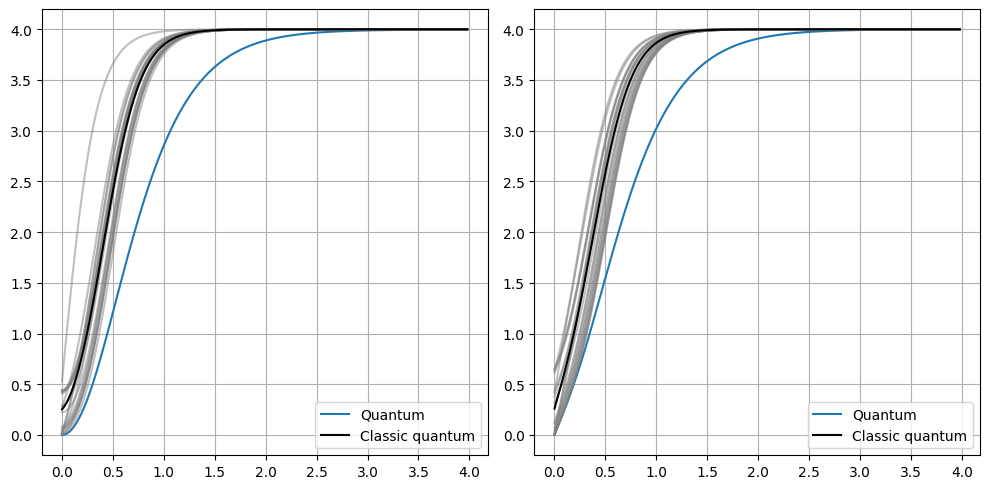

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
n_traj = 20
ax[0].plot(tsaves, output_1_m.expects[0], label='Quantum')
ax[0].plot(t_classic, sol_classic_q[np.random.randint(n_shots, size=n_traj), :, 0].T, c='grey', alpha=0.5)
ax[0].plot(t_classic, sol_classic_q.mean(axis=0)[:, 0], c='k', label='Classic quantum')
ax[0].legend()
ax[0].grid()

ax[1].plot(tsaves, output_1_m.expects[1], label='Quantum')
ax[1].plot(t_classic, sol_classic_q[np.random.randint(n_shots, size=n_traj), :, 1].T, c='grey', alpha=0.5)
ax[1].plot(t_classic, sol_classic_q.mean(axis=0)[:, 1], c='k', label='Classic quantum')
ax[1].legend()
ax[1].grid()
fig.tight_layout()
plt.show()

# Making large test of asymetric_sigmoid fit on data

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import dynamiqs as dq
import numpy as np
from scipy.optimize import curve_fit

## Defining asym_sigmoid

In [2]:
def extended_exp(t, alpha):
    if alpha == 1:
        return jnp.exp(t)
    calpha = 1/(alpha-1)
    return (1-t/calpha)**(1/(1-alpha))

In [3]:
def asym_sigmoid(t, t0, A, T_inflate, alpha):
    t0 += 2*T_inflate
    if alpha == 1:
        return A / (1 + jnp.exp(-(t - t0) / T_inflate))
    calpha = 1/(alpha-1)
    xs = -(t - t0) / T_inflate
    xs_sup = xs >= calpha
    xs_inf = xs < calpha
    ext_exp_loc = extended_exp(xs, alpha)
    sigmoid_res = A / (1 + ext_exp_loc)
    if alpha < 1:
        sigmoid_res = sigmoid_res.at[xs_inf].set(A)
    else:
        sigmoid_res = sigmoid_res.at[xs_sup].set(0)
    return sigmoid_res

2024-06-24 17:29:15.383612: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


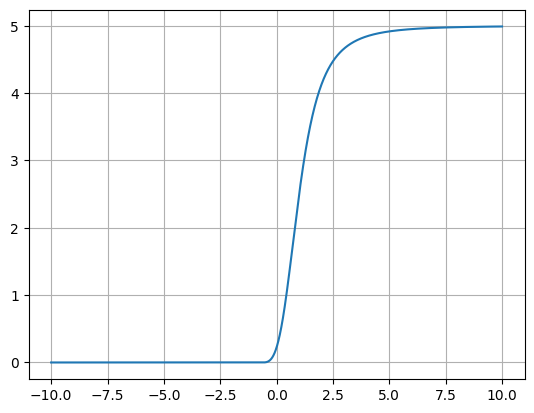

In [4]:
fig, ax = plt.subplots()
time = jnp.linspace(-1, 1, 2001)*10
ax.plot(time, asym_sigmoid(time, 0, 5, 0.5, 1.3))
ax.grid()
plt.show()

## Simulation database

In [5]:
MHz = 2*jnp.pi
us = 1

In [6]:
Na, Nb = 20, 15

a, b = dq.destroy(Na, Nb)

kappa_b = 15*MHz

n_t = 501

rho0 = dq.tensor(dq.fock(Na, 0), dq.fock(Nb, 0))

In [7]:
def H_inflate(g2, eds, a, b):
    H = g2*a@a@dq.dag(b) + eds*b
    return H+dq.dag(H)

In [8]:
def simulate(alpha_m_2, g2):
    eds = alpha_m_2*g2
    H = H_inflate(g2, eds[:, None, None], a[None, :, :], b[None, :, :])
    c_ops = [jnp.sqrt(kappa_b)*b]
    kappa_2 = 4*g2**2/kappa_b
    kappa_conf = kappa_2*alpha_m_2
    tsave = jnp.linspace(0, 10/jnp.min(kappa_conf), n_t)
    output = dq.mesolve(H, c_ops, rho0, tsave, exp_ops=[dq.dag(a)@a, a@dq.dag(a) - dq.dag(a)@a, b@dq.dag(b) - dq.dag(b)@b])
    return output.expects, tsave

In [9]:
alphas_m_2 = jnp.linspace(2, 6, 5)
g2s = jnp.linspace(0.5, 4, 8)*MHz

results = jnp.zeros((len(g2s), len(alphas_m_2), 3, n_t), dtype=complex)
tsaves = jnp.zeros((len(g2s), n_t))
for ind, g2 in enumerate(g2s):
    expects, tsave = simulate(alphas_m_2, g2)
    results = results.at[ind].set(expects)
    tsaves = tsaves.at[ind].set(tsave)

2024-06-24 17:29:17.202623: W external/xla/xla/service/hlo_rematerialization.cc:2948] Can't reduce memory use below 3.97GiB (4264764731 bytes) by rematerialization; only reduced to 4.03GiB (4330290927 bytes), down from 4.03GiB (4330290927 bytes) originally
|███████████████████████████████████████████████████████████| 100.0% ◆ total 7.95s ◆ remaining 00:00
|███████████████████████████████████████████████████████████| 100.0% ◆ total 2.99s ◆ remaining 00:00
|███████████████████████████████████████████████████████████| 100.0% ◆ total 1.76s ◆ remaining 00:00
|███████████████████████████████████████████████████████████| 100.0% ◆ total 1.26s ◆ remaining 00:00
|███████████████████████████████████████████████████████████| 100.0% ◆ total 0.91s ◆ remaining 00:00
|███████████████████████████████████████████████████████████| 100.0% ◆ total 0.73s ◆ remaining 00:00
|███████████████████████████████████████████████████████████| 100.0% ◆ total 0.62s ◆ remaining 00:00
|███████████████████████████████████

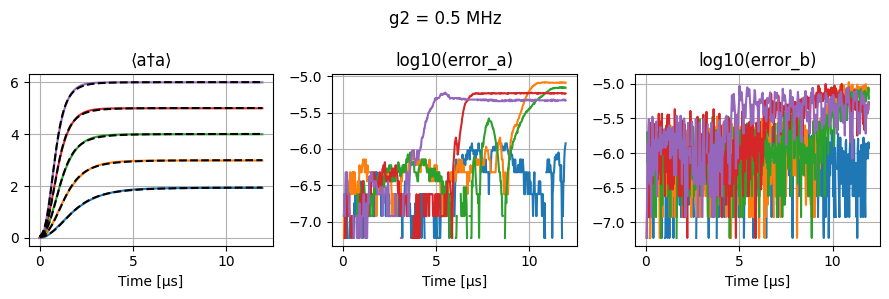

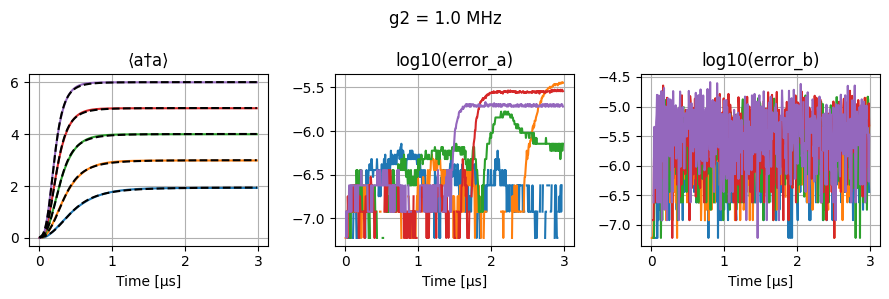

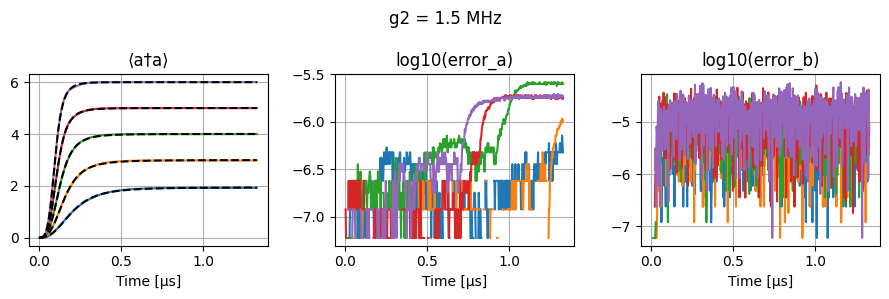

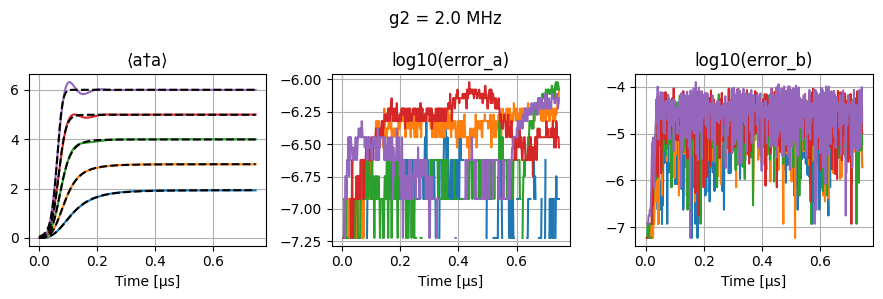

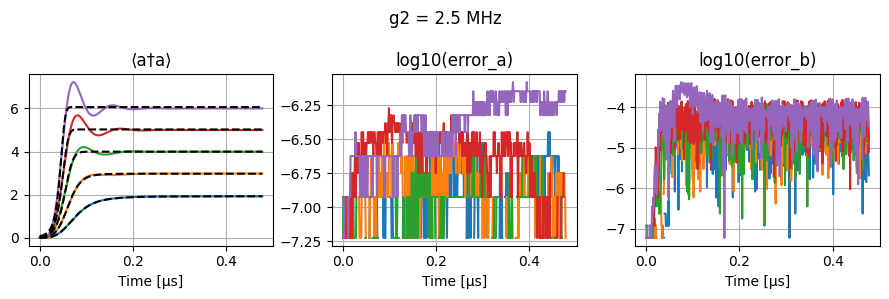

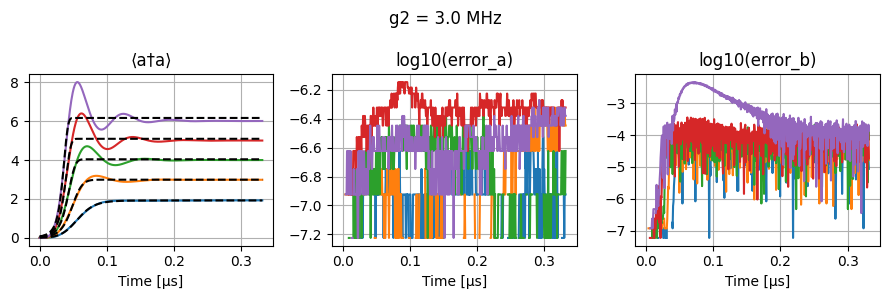

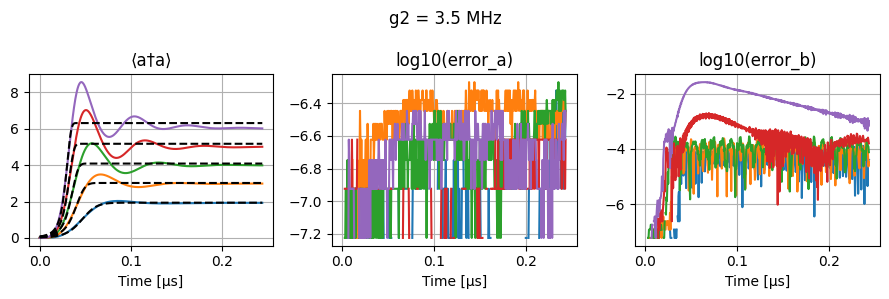

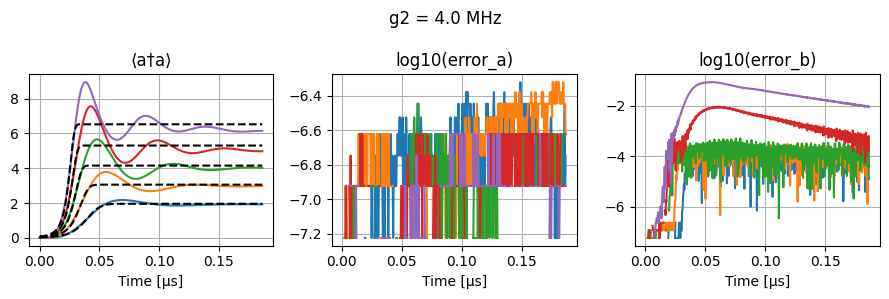

In [10]:
popts = np.zeros((len(g2s), len(alphas_m_2), 4))
for ind, g2_plot in enumerate(g2s):
    fig, ax = plt.subplots(1, 3, figsize=(9, 3))
    ax[0].plot(tsaves[ind], results[ind, :, 0].real.T)
    for ind_al, alpha_2 in enumerate(alphas_m_2):
        kappa_2 = 4*g2_plot**2/kappa_b
        T_infl = 1/2/kappa_2/alpha_2
        guess = [0, alpha_2, T_infl, 1]
        #ax[0].plot(tsaves[ind], ext_sigmoid(tsaves[ind], *guess), "k--")
        popt, _ = curve_fit(asym_sigmoid, tsaves[ind], results[ind, ind_al, 0].real, p0=guess)
        ax[0].plot(tsaves[ind], asym_sigmoid(tsaves[ind], *popt), "k--")
        popts[ind, ind_al, :len(popt)] = popt
        
    ax[0].set_title('⟨a†a⟩')
    ax[1].plot(tsaves[ind], jnp.log10(jnp.abs(results[ind, :, 1].real.T-1)))
    ax[1].set_title('log10(error_a)')
    ax[2].plot(tsaves[ind], jnp.log10(jnp.abs(results[ind, :, 2].real.T-1)))
    ax[2].set_title('log10(error_b)')

    for sa in ax.flatten():
        sa.grid()
        sa.set_xlabel('Time [µs]')
    fig.suptitle(f'g2 = {g2_plot/MHz} MHz')
    fig.tight_layout()
    plt.show()

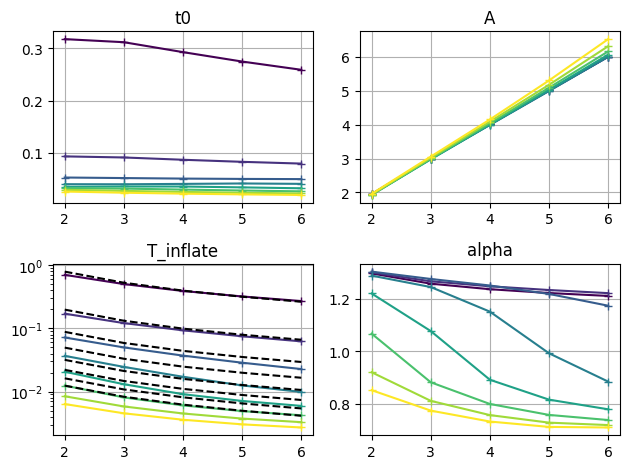

In [13]:
fig, ax = plt.subplots(2, 2)
cmap = plt.get_cmap('viridis')
for sa, d, t in zip(ax.flatten(), np.swapaxes(popts, -1, 0), ["t0", "A", "T_inflate", "alpha"]):
    for ind, sub_d in enumerate(d.T):
        sa.plot(alphas_m_2, sub_d, "+-", c=cmap(ind/(len(g2s)-1)))
    sa.grid()
    sa.set_title(t)
kappas_2 = 4*g2s**2/kappa_b
T_inf_th = 1/kappas_2[None, :]/alphas_m_2[:, None]/1.5
ax[1, 0].plot(alphas_m_2, T_inf_th, 'k--')
ax[1, 0].set_yscale('log')
fig.tight_layout()

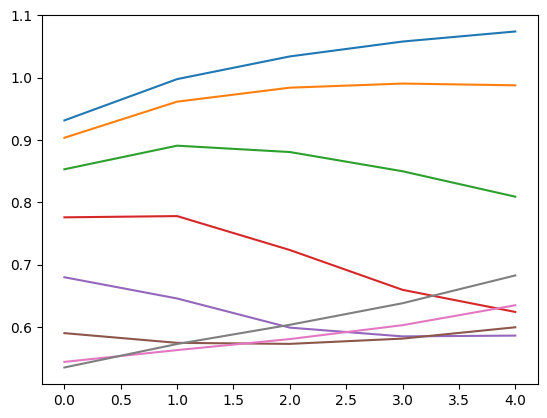

In [12]:
plt.plot(popts[:, :, 2].T/T_inf_th)

## Analysing oscillating trace

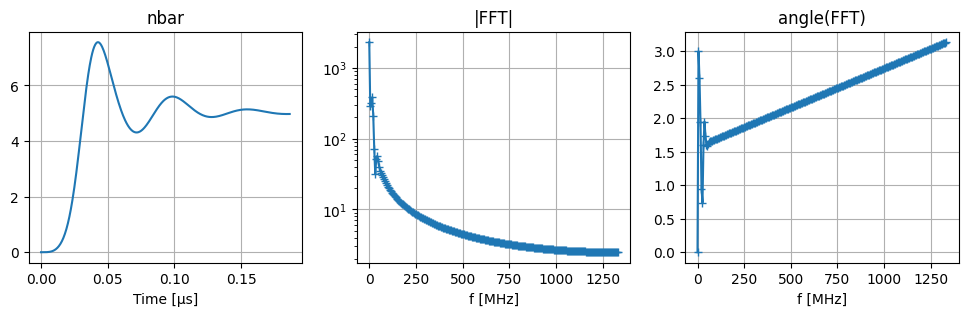

In [13]:
ind_g2, ind_alpha = -1, 3
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
ax[0].plot(tsaves[ind_g2], results[ind_g2, ind_alpha, 0].real)
ax[0].grid()
ax[0].set_xlabel('Time [µs]')
ax[0].set_title('nbar')

fft = jnp.fft.fft(results[ind_g2, ind_alpha, 0].real)
freqs = jnp.fft.fftfreq(len(tsaves[ind_g2]), tsaves[ind_g2, 1])
nfft = len(fft)
ax[1].plot(freqs[:nfft//2], np.abs(fft)[:nfft//2], '+-')
ax[1].set_yscale('log')
ax[1].set_xlabel('f [MHz]')
ax[1].set_title('|FFT|')
ax[1].grid()

ax[2].plot(freqs[:nfft//2], np.angle(fft)[:nfft//2], '+-')
ax[2].set_xlabel('f [MHz]')
ax[2].set_title('angle(FFT)')
ax[2].grid()
plt.show()

## Testing scale invariance

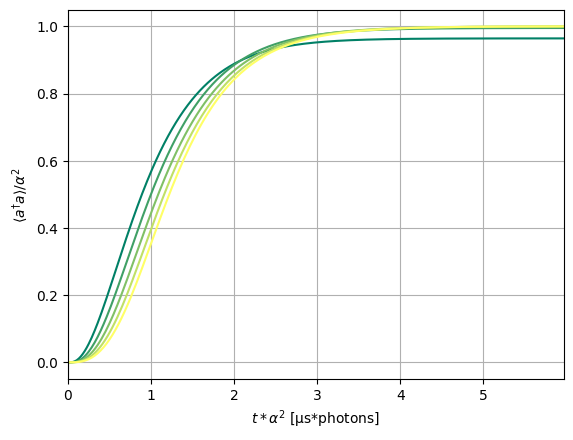

In [18]:
fig, ax = plt.subplots()
ind_g2 = 1
cmap = plt.get_cmap('summer')
for ind_alpha, alpha_2 in enumerate(alphas_m_2):
    ax.plot(tsaves[ind_g2]*alphas_m_2[ind_alpha], results[ind_g2, ind_alpha, 0].real.T/alphas_m_2[ind_alpha], c=cmap(ind_alpha/(len(alphas_m_2)-1)))
    # ax.plot(tsaves[ind_g2], results[ind_g2, ind_alpha, 0].real.T, c=cmap(ind_alpha/(len(alphas_m_2)-1)))
ax.grid()
ax.set_ylabel(r'$\langle a^\dag a \rangle/\alpha^2$')
ax.set_xlabel(r'$t*\alpha^2$ [µs*photons]')
ax.set_xlim(0, tsaves[ind_g2, -1]*alphas_m_2[0])
plt.show()

# Test on evolution

In [11]:
import dynamiqs as dq
import jax.numpy as jnp

In [12]:
MHz = 2*jnp.pi
us = 1

In [29]:
Na, Nb = 30, 30
alpha_inf = 5
g2 = 1*MHz
kappa_b = 10*MHz
n_t = 101
rho0 = dq.tensor(dq.coherent(Na, 0), dq.coherent(Nb, 0))

In [30]:
def simulate_2_photon(alpha_m_2, g2):
    a, b = dq.destroy(Na, Nb)
    
    eds = -alpha_m_2*g2
    H = g2*a@a@dq.dag(b) + eds*b
    H += dq.dag(H)
    
    c_ops = [jnp.sqrt(kappa_b)*b]
    
    tsave = jnp.linspace(0, 20/kappa_b, n_t)
    output = dq.mesolve(H, c_ops, rho0, tsave)
    return output, tsave

In [31]:
out, times = simulate_2_photon(alpha_inf, g2)

|███████████████████████████████████████████████████████████| 100.0% ◆ total 1.73s ◆ remaining 00:00


100%|███████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.75it/s]


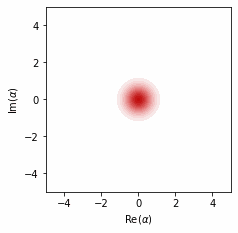

100%|███████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.78it/s]


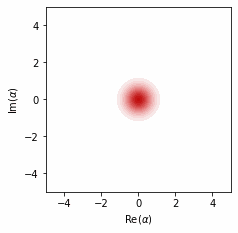

In [32]:
dq.plot_wigner_gif(dq.ptrace(out.states, 0, (Na, Nb)))
plt.show()
dq.plot_wigner_gif(dq.ptrace(out.states, 1, (Na, Nb)))
plt.show()

In [33]:
def simulate_1_photon(alpha_m_2, g1):
    a, b = dq.destroy(Na, Nb)
    
    eds = -jnp.sqrt(alpha_m_2)*g1
    H = g1*a@dq.dag(b) + eds*b
    H += dq.dag(H)
    
    c_ops = [jnp.sqrt(kappa_b)*b]
    
    tsave = jnp.linspace(0, 20/kappa_b, n_t)
    
    output = dq.mesolve(H, c_ops, rho0, tsave)
    return output, tsave

In [34]:
out_1_photon, times_1_photon = simulate_1_photon(alpha_inf, g2**2)

|███████████████████████████████████████████████████████████| 100.0% ◆ total 2.92s ◆ remaining 00:00


100%|███████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.05it/s]


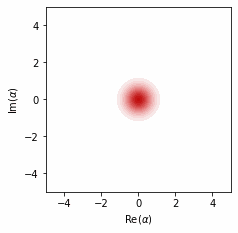

100%|███████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.93it/s]


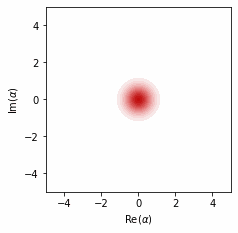

In [35]:
dq.plot_wigner_gif(dq.ptrace(out_1_photon.states, 0, (Na, Nb)))
plt.show()
dq.plot_wigner_gif(dq.ptrace(out_1_photon.states, 1, (Na, Nb)))
plt.show()

/home/rroussea/.pyenv/versions/3.11.9/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/rroussea/.pyenv/versions/3.11.9/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


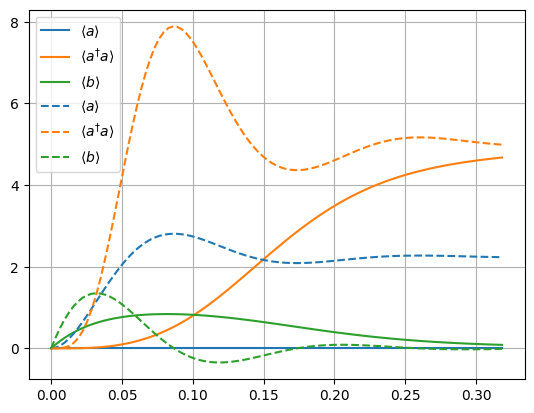

In [36]:
a, b = dq.destroy(Na, Nb)
plt.plot(out.tsave, dq.expect(a, out.states), 'C0', label=r'$\langle a \rangle$')
plt.plot(out.tsave, dq.expect(dq.dag(a)@a, out.states), 'C1', label=r'$\langle a^\dag a \rangle$')
plt.plot(out.tsave, dq.expect(b, out.states).imag, 'C2', label=r'$\langle b \rangle$')
plt.plot(out.tsave, dq.expect(a, out_1_photon.states), 'C0--', label=r'$\langle a \rangle$')
plt.plot(out.tsave, dq.expect(dq.dag(a)@a, out_1_photon.states), 'C1--', label=r'$\langle a^\dag a \rangle$')
plt.plot(out.tsave, dq.expect(b, out_1_photon.states).imag, 'C2--', label=r'$\langle b \rangle$')
plt.legend()
plt.grid()
plt.show()